In [1]:
pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 wh

best model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
ENV_NAME      = "CartPole-v1"
GAMMA         = 0.99
LR            = 1e-3
MAX_EPISODES  = 10000
NUM_WORKERS   = 2
ENTROPY_BETA  = 0.005
GRAD_CLIP     = 0.5

torch.manual_seed(0)

In [2]:
# Actor-Critic Network stays the same
class ActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.fc1    = nn.Linear(input_dim, 256)
        self.fc2    = nn.Linear(256, 128)
        self.policy = nn.Linear(128, output_dim)
        self.value  = nn.Linear(128, 1)

    def forward(self, x):
        x      = F.relu(self.fc1(x))
        x      = F.relu(self.fc2(x))
        logits = self.policy(x)
        value  = self.value(x)
        return logits, value

In [ ]:
class Worker(mp.Process):
    def __init__(self, gnet, optimizer_fn, global_ep, res_queue, best_reward, name):
        super(Worker, self).__init__()
        self.name       = f"worker_{name}"
        self.gnet       = gnet
        self.optimizer_fn = optimizer_fn
        self.global_ep  = global_ep
        self.res_queue  = res_queue
        self.best_reward = best_reward

        #creating env and grabbing its max steps per episode
        self.env        = gym.make(ENV_NAME)
        #making use of Gym’s TimeLimit wrapper stores max steps here:
        self.max_steps  = getattr(self.env, '_max_episode_steps',
                                  getattr(self.env.spec, 'max_episode_steps', None))

        self.local_net  = ActorCritic(self.env.observation_space.shape[0],
                                      self.env.action_space.n)

    def run(self):
        while self.global_ep.value < MAX_EPISODES:
            ep_idx = self.global_ep.value
            lr_decay= max(1e-4, LR * (1 - ep_idx / MAX_EPISODES)) #Dynamic Learning Rate
            optimizer = self.optimizer_fn(self.gnet.parameters(), lr=lr_decay)

            state  = self.env.reset()
            log_probs   = []
            values = []
            rewards = []
            entropies = []
            ep_reward = 0
            done = False
            step = 0

            #we are running until pole falls or env’s max
            while not done and (self.max_steps is None or step < self.max_steps):
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                logits, value = self.local_net(state_tensor)
                probs         = F.softmax(logits, dim=-1)

                dist          = torch.distributions.Categorical(probs)
                action        = dist.sample()

                next_state, reward, done, _ = self.env.step(action.item())
                reward = np.clip(reward, 0, 1) #normalize returns

                log_probs.append(dist.log_prob(action))
                entropies.append(dist.entropy())
                values.append(value)
                rewards.append(reward)
                ep_reward += reward

                with self.best_reward.get_lock():
                  if ep_reward > self.best_reward.value:
                      self.best_reward.value = ep_reward
                      torch.save(self.gnet.state_dict(), "best_a2c_cartpole.pth")
                      # print(f"[{self.name}] New best model saved with reward: {ep_reward:.2f}")


                state = next_state
                step += 1

            #bootstrap if not done check 
            if done:
                R = 0.0
            else:
                with torch.no_grad():
                    _, v = self.local_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                    R = v.item()

            #compute discounted returns
            returns = []
            for r in reversed(rewards):
                R = r + GAMMA * R
                returns.insert(0, R)
            returns = torch.tensor(returns, dtype=torch.float32)
            returns = (returns - returns.mean()) / (returns.std() + 1e-5)

            log_probs = torch.stack(log_probs)
            values    = torch.cat(values).squeeze()
            entropies = torch.stack(entropies)
#calculate adv and respectiove losses 
            advantage    = returns - values

            actor_loss   = -(log_probs * advantage.detach()).mean()
            critic_loss  = advantage.pow(2).mean()

            entropy_loss = entropies.mean()
            total_loss   = actor_loss + critic_loss - ENTROPY_BETA * entropy_loss

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.local_net.parameters(), GRAD_CLIP)

            #push gradients to global net
            for lp, gp in zip(self.local_net.parameters(),
                              self.gnet.parameters()):
                if lp.grad is not None:
                    gp_grad = lp.grad.clone()
                    if gp.grad is None:
                        gp.grad = gp_grad
                    else:
                        gp.grad += gp_grad

            optimizer.step()
            #syncing local network
            self.local_net.load_state_dict(self.gnet.state_dict()) #Keep local network in sync after pushing gradients

            with self.global_ep.get_lock():
                self.global_ep.value += 1

            self.res_queue.put((self.name, ep_reward))

In [ ]:
def train():
    best_reward = mp.Value('d', float('-inf')) #Initialize Shared State
    global_net   = ActorCritic(4, 2) #Global network with input size 4 and output size 2
    global_net.share_memory()
    optimizer_fn = torch.optim.Adam

    global_ep = mp.Value('i', 0)
    res_queue = mp.Queue()

    workers = [Worker(global_net, optimizer_fn, global_ep, res_queue,best_reward, i) #Create and Start Workers
               for i in range(NUM_WORKERS)]
    for w in workers:
        w.start()

    rewards = [] #Collect Episode Rewards
    while True:
        name, reward = res_queue.get()
        ep_num = len(rewards) + 1
        if ep_num % 10 == 0:
            print(f"[{name}] Episode {ep_num}/{MAX_EPISODES} | Reward: {reward:.2f}")
        rewards.append(reward)
        if global_ep.value >= MAX_EPISODES:
            break

    for w in workers: #Join Workers
        w.join()

    torch.save(global_net.state_dict(), "a2c_cartpole.pth")
    print("Saved model to a2c_cartpole.pth")
    return rewards, global_net

In [ ]:
def evaluate(model, episodes=10, render=False):
    env = gym.make(ENV_NAME)
    total_rewards = []

    for ep in range(episodes):
        state = env.reset()
        done  = False
        ep_reward = 0

        while not done:
            if render:
                env.render()
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            logits, _    = model(state_tensor)
            action       = torch.argmax(F.softmax(logits, dim=-1)).item()
            state, reward, done, _ = env.step(action)
            ep_reward   += reward

        print(f"Evaluation Episode {ep+1}: Reward = {ep_reward}")
        total_rewards.append(ep_reward)

    env.close()
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"\nAverage Reward over {episodes} episodes: {avg_reward:.2f} ± {std_reward:.2f}")
    return total_rewards

[worker_1] Episode 10/10000 | Reward: 26.00
[worker_0] Episode 20/10000 | Reward: 20.00
[worker_0] Episode 30/10000 | Reward: 20.00
[worker_1] Episode 40/10000 | Reward: 23.00
[worker_1] Episode 50/10000 | Reward: 11.00
[worker_0] Episode 60/10000 | Reward: 11.00
[worker_1] Episode 70/10000 | Reward: 10.00
[worker_1] Episode 80/10000 | Reward: 12.00
[worker_1] Episode 90/10000 | Reward: 10.00
[worker_1] Episode 100/10000 | Reward: 16.00
[worker_1] Episode 110/10000 | Reward: 13.00
[worker_1] Episode 120/10000 | Reward: 11.00
[worker_1] Episode 130/10000 | Reward: 10.00
[worker_1] Episode 140/10000 | Reward: 10.00
[worker_1] Episode 150/10000 | Reward: 11.00
[worker_0] Episode 160/10000 | Reward: 9.00
[worker_0] Episode 170/10000 | Reward: 10.00
[worker_0] Episode 180/10000 | Reward: 9.00
[worker_1] Episode 190/10000 | Reward: 10.00
[worker_0] Episode 200/10000 | Reward: 9.00
[worker_1] Episode 210/10000 | Reward: 9.00
[worker_1] Episode 220/10000 | Reward: 10.00
[worker_1] Episode 230/

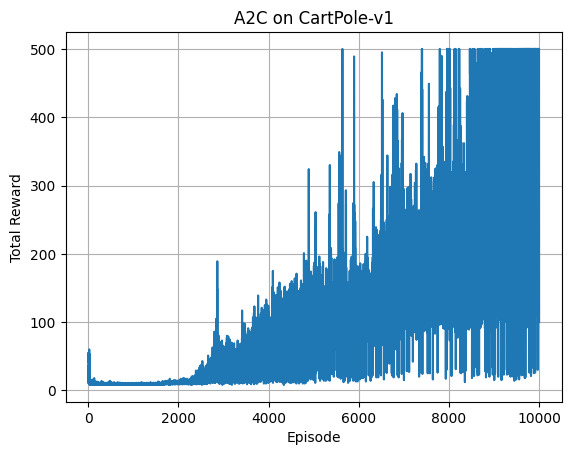

In [7]:
if __name__ == "__main__":
    rewards, final_model = train()
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("A2C on CartPole-v1")
    plt.grid()
    plt.show()


Running Evaluation...
Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0

Average Reward over 10 episodes: 500.00 ± 0.00


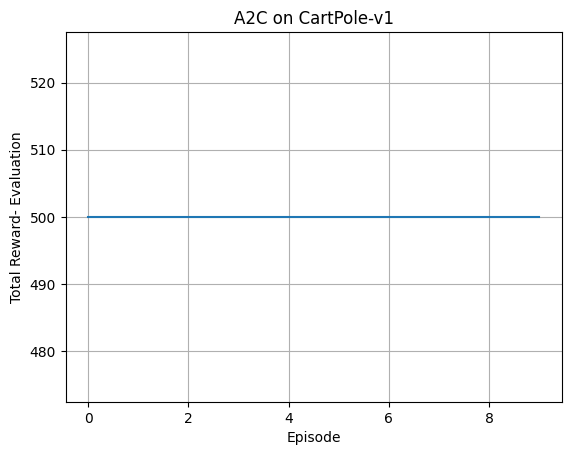

In [8]:
print("\nRunning Evaluation...")
eval_rewards=evaluate(final_model, episodes=10, render=False)
plt.plot(eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward- Evaluation")
plt.title("A2C on CartPole-v1")
plt.grid()
plt.show()